<a href="https://colab.research.google.com/github/Makoto-Noda/google-Colab/blob/main/CatsDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/jeffd23/catdognet-keras-convnet-starter

In [52]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import keras.utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
import json
f = open("/content/drive/MyDrive/kaggle.json", 'r')
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

In [8]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 98% 800M/814M [00:13<00:00, 136MB/s]
100% 814M/814M [00:13<00:00, 64.4MB/s]


トレーニングデータ・テストデータの作成

In [13]:
TRAIN_DIR = './train/'
TEST_DIR = './test/'

In [14]:
ROWS = 64
COLS = 64
CHANNELS = 3

In [16]:
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [17]:
train_images = train_dogs[:1000] + train_cats[:1000]
random.shuffle(train_images)
test_images =  test_images[:25]

In [20]:
def read_image(file_path):

    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

    return img


def prep_data(images):

    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))

    return data


train = prep_data(train_images)
test = prep_data(test_images)

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
Processed 0 of 25


In [34]:
labels = []

for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

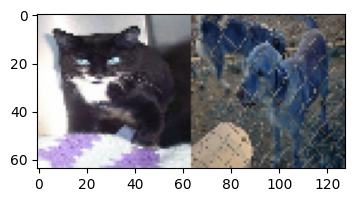

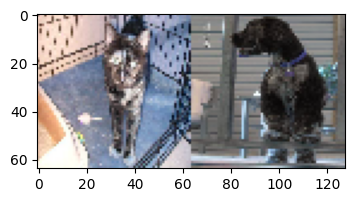

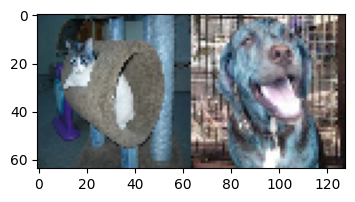

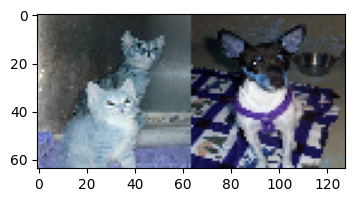

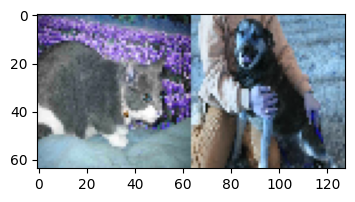

In [36]:
def show_cats_and_dogs(idx):

    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(5,2))
    plt.imshow(pair)
    plt.show()

    return idx

for idx in range(0,5):
    show_cats_and_dogs(idx)

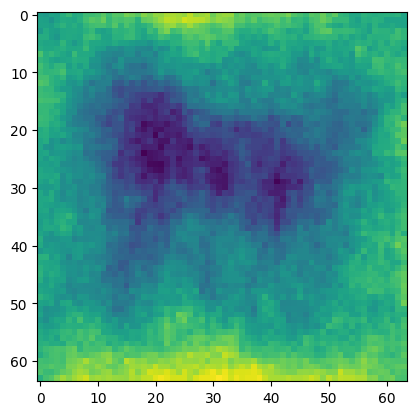

In [49]:
dog_avg = np.array([dog[0].T for i, dog in enumerate(train) if labels[i]==1]).mean(axis=0)
cat_avg = np.array([cat[0].T for i, cat in enumerate(train) if labels[i]==0]).mean(axis=0)

plt.imshow(dog_avg)

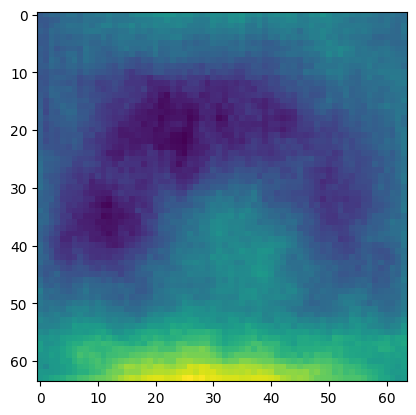

In [50]:
plt.imshow(cat_avg)

CatdogNet-16の実装

In [57]:
from keras.src.layers.convolutional.conv2d_transpose import Conv2D
optimizer = RMSprop(learning_rate=1e-4)
objective = 'binary_crossentropy'

def catdog():

    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))

    #model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
    #model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
    #model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

model = catdog()